# Initialization


In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
import warnings


Hiding data conversion warnings generated by standard scaler.
Standard scaler expects float as input and converts input to float throwing a warning message.

In [6]:
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


Reading part (1/n) of the data

In [7]:
def skiprow(i, n):
    if i % n == 0:
       return False
    return True


Change n to load more, or less of the data.

In [8]:
n=10
train_url='https://github.com/shobhitshah/MNIST-digit-recognizer/blob/develop/data/mnist-in-csv/mnist_train.csv.zip?raw=true'
test_url='https://github.com/shobhitshah/MNIST-digit-recognizer/blob/develop/data/mnist-in-csv/mnist_test.csv.zip?raw=true'
train = pd.read_csv(train_url, compression='zip', skiprows = lambda x: skiprow(x, n))
test = pd.read_csv(test_url, compression='zip' , skiprows = lambda x: skiprow(x, 1))

train.shape

(6000, 785)

In [9]:
train.sample(5)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
1641,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5785,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2314,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1265,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1919,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Feature selection

In [10]:
y=train.label
X=train.drop('label', axis=1)
X_test = test.drop('label', axis=1)


# Define models

Multi label models.

In [11]:
models = []
models.append(('KNN', KNeighborsClassifier(5)))
models.append(('Linear SVM', SVC(gamma='scale', C=1, decision_function_shape='ovo')))
models.append(('Neural Net', MLPClassifier(alpha=0.0001, solver='sgd')))
#models.append(('XGB', XGBClassifier(objective='multi:softmax', num_class=10)))
models.append(('LR', LogisticRegression(solver="saga", multi_class="multinomial", max_iter=1000))) # ovr - one versus reset
models.append(('RF', RandomForestClassifier(max_depth=5, n_estimators=10)))


# Model fitting and prediction

In [12]:
def model_score(name, model, X, y, val_y, y_pred, y_test, icv):
    #print('Running CV score')
    cvscore = cross_val_score(model, X, y, cv=icv)
    print('Model {0} score: {1:.4f} and std dev: {2:.4f}'.format(name, cvscore.mean(), cvscore.std()))
    print('Validation variance score: %.4f' % r2_score(val_y, y_pred))
    print('Test variance score: %.4f' % r2_score(test.label, y_test))

    return cvscore, r2_score(val_y, y_pred), r2_score(test.label, y_test)

In [13]:
def cv_fit_and_predict(models, X, y):
    results = []
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
    for name, model in models:
        #print("Fitting model {}".format(name))
        clf = make_pipeline(StandardScaler(), model)
        m = clf.fit(train_X, train_y)
        #print("Fitted model is {}".format(m))
        #print('Running prediction')
        y_pred = clf.predict(val_X)
        y_test = clf.predict(X_test)
        score, val_r2, test_r2 = model_score(name, clf, X, y, val_y, y_pred, y_test, 10)
        results.append((name, score, val_r2, test_r2))

        m = model.fit(train_X, train_y)
        y_pred = model.predict(val_X)
        y_test = model.predict(X_test)
        score, val_r2, test_r2 = model_score(name+"_U", model, X, y, val_y, y_pred, y_test, 10)
        results.append((name+"_U", score, val_r2, test_r2))
    print("Done")
    return results


In [14]:
results = cv_fit_and_predict(models, X, y)

Model KNN score: 0.9255 and std dev: 0.0098
Validation variance score: 0.8617
Test variance score: 0.7497
Model KNN_U score: 0.9573 and std dev: 0.0081
Validation variance score: 0.9190
Test variance score: 0.8288
Model Linear SVM score: 0.9457 and std dev: 0.0076
Validation variance score: 0.9246
Test variance score: 0.8239
Model Linear SVM_U score: 0.1640 and std dev: 0.0100
Validation variance score: -2.1504
Test variance score: -2.3526


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: Conve

Model Neural Net score: 0.9412 and std dev: 0.0115
Validation variance score: 0.8974
Test variance score: 0.7830


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: Conve

Model Neural Net_U score: 0.7634 and std dev: 0.1162
Validation variance score: 0.7351
Test variance score: 0.6233


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Library/Fra

Model LR score: 0.9178 and std dev: 0.0117
Validation variance score: 0.8586
Test variance score: 0.7360


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Library/Fra

Model LR_U score: 0.9095 and std dev: 0.0138
Validation variance score: 0.8562
Test variance score: 0.7117
Model RF score: 0.8524 and std dev: 0.0281
Validation variance score: 0.6967
Test variance score: 0.5986
Model RF_U score: 0.8403 and std dev: 0.0239
Validation variance score: 0.6662
Test variance score: 0.5609
Done


# Validation and results

In [18]:
def model_validation(results):
    fig, ax = plt.subplots(figsize=(13, 8))
    ax.boxplot(results[:,1])
    ax.set_xticklabels(results[:,0])
    ax.set_title('Model CV score')
    plt.show()
    
    plt.figure(figsize=(13, 8))
    plt.bar(results[:,0], results[:,2])
    plt.xlabel('Models')
    plt.ylabel('Var score')
    plt.title('Models variance score')
    plt.show()
    
    plt.figure(figsize=(8, 5))
    plt.bar(results[:,0], results[:,3])
    plt.xlabel('Models')
    plt.ylabel('Var score')
    plt.title('Test variance score')
    plt.show()
    
    return 0

In [19]:
np_results=np.array(results, object)

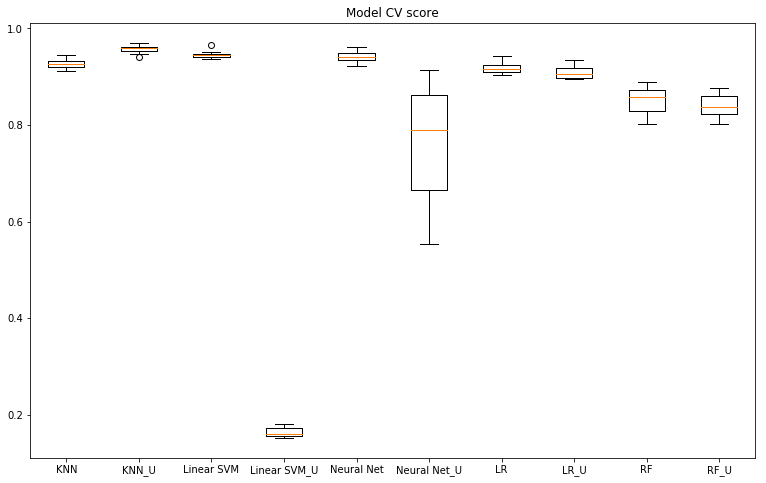

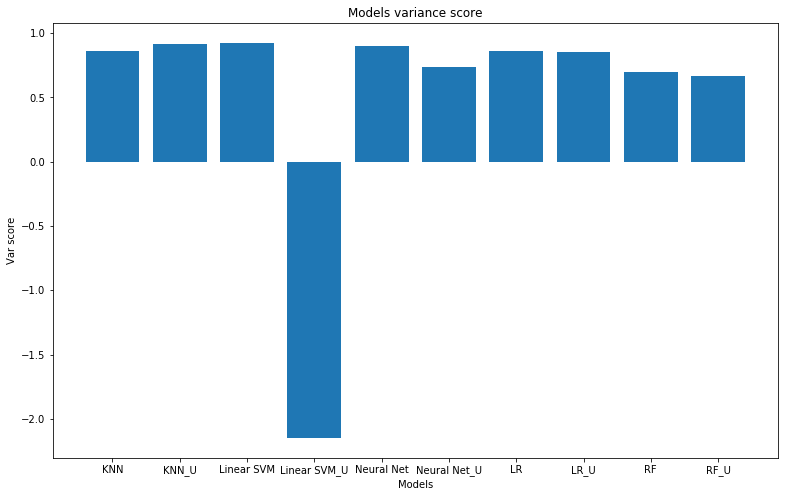

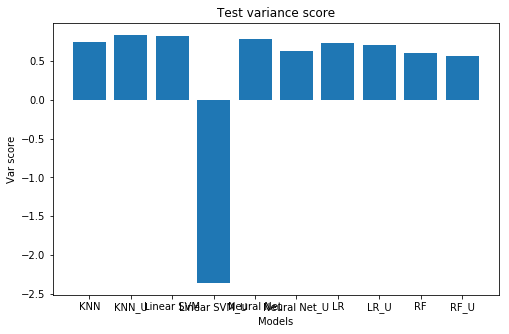

In [20]:
status = model_validation(np_results)